# Branch Support Analysis

---
## Questions

### 1. How much phylogenetic signal is present in the Yersinia pestis phylogeny?

---
## Setup

### Module Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors, lines, patches, gridspec
import seaborn as sns

import pandas as pd

from Bio import Phylo

import os

### Input File Paths

In [2]:
tree_path = "../../docs/results/2020-11-09/iqtree/iqtree-core_chromosome.filter5.treefile"
outdir = "../../docs/results/latest/branch_support"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

### Variables

In [3]:
# Branch Support Thresholds (from IQTREE docs)
ALRT_THRESH = 80
UFBOOT_THRESH = 95

NO_DATA_CHAR = "NA"

### Plotting Configuration

In [4]:
# Colors
HIGH_COL = "red"
LOW_COL = "black"
TERM_COL = "grey"
THRESH_COL = "blue"

# Graphics
figsize=(6.4,4.8)
figsize_alt=(9.6,4.8)
dpi=400

# Font
SM_FONT = 5
MED_FONT = 8
LG_FONT = 10

plt.rc('font', size=SM_FONT)          # controls default text sizes
plt.rc('figure', titlesize=LG_FONT)  # fontsize of the figure title
#plt.rc('axes', labelsize=MED_FONT)    # fontsize of the x and y labels

# Lines
plt.rc('lines', linewidth=1)

---
## Analysis

### Convert newick tree to temporary XML

In [5]:
tmp_xml = os.path.join(outdir, "temp.xml")
Phylo.convert(tree_path, "newick", tmp_xml, "phyloxml")

1

### Create tree dataframe

In [6]:
# Read in the new tree
tree_div = Phylo.read(tmp_xml, "phyloxml")

# Deepest nodes first
tree_div.ladderize(reverse=True)

# initialize empty dataframe
tree_df = pd.DataFrame(columns = ["Name", "UFboot", "aLRT", "Branch_Support_Color", "Branch_Length"])

# Counters
node_i = 0

# Iterate through the nodes in the tree
for c in tree_div.find_clades():
    # ---------------------------------
    # Fix  Names and Confidences
    # ---------------------------------
    if not c.name:
        continue
    name_split = c.name.split("/")
    # Check if the name has 'accidentally' become the confidence vals
    alrt_val = NO_DATA_CHAR
    ufboot_val = NO_DATA_CHAR
    
    if len(name_split) == 2:
        # Name the internal node
        c.name = "NODE" + str(node_i)    

        # Assign confidence values
        alrt_val = float(name_split[0])
        alrt_conf = Phylo.PhyloXML.Confidence(alrt_val, type="alrt")
        
        ufboot_val = float(name_split[1])
        ufboot_conf = Phylo.PhyloXML.Confidence(ufboot_val, type="ufboot")
        
        c.confidences.append(alrt_conf)
        c.confidences.append(ufboot_conf)
        
    # ---------------------------------
    # Branch Support Color
    # ---------------------------------
    
    # Default Color
    node_color = LOW_COL
    # Terminal branches will be grey
    if c.is_terminal():
        node_color = TERM_COL
    # High support branches
    if alrt_val != "NA" and ufboot_val != "NA":
        if alrt_val >= ALRT_THRESH and ufboot_val >= UFBOOT_THRESH:
            node_color = HIGH_COL
    c.color = node_color
    node_data = {
        "Name" : c.name,
        "UFboot" : ufboot_val,
        "aLRT" : alrt_val,
        "Branch_Support_Color" : node_color,
        "Branch_Length" : c.branch_length
    }
    tree_df = tree_df.append(node_data, ignore_index=True)
    
    # Increment node counter
    node_i += 1

tree_df.set_index("Name", inplace=True)

### Save tree dataframe

In [87]:
out_path = os.path.join(outdir, "branch-support.tsv" )
tree_df.to_csv(out_path, sep="\t")

---
## Plotting

1

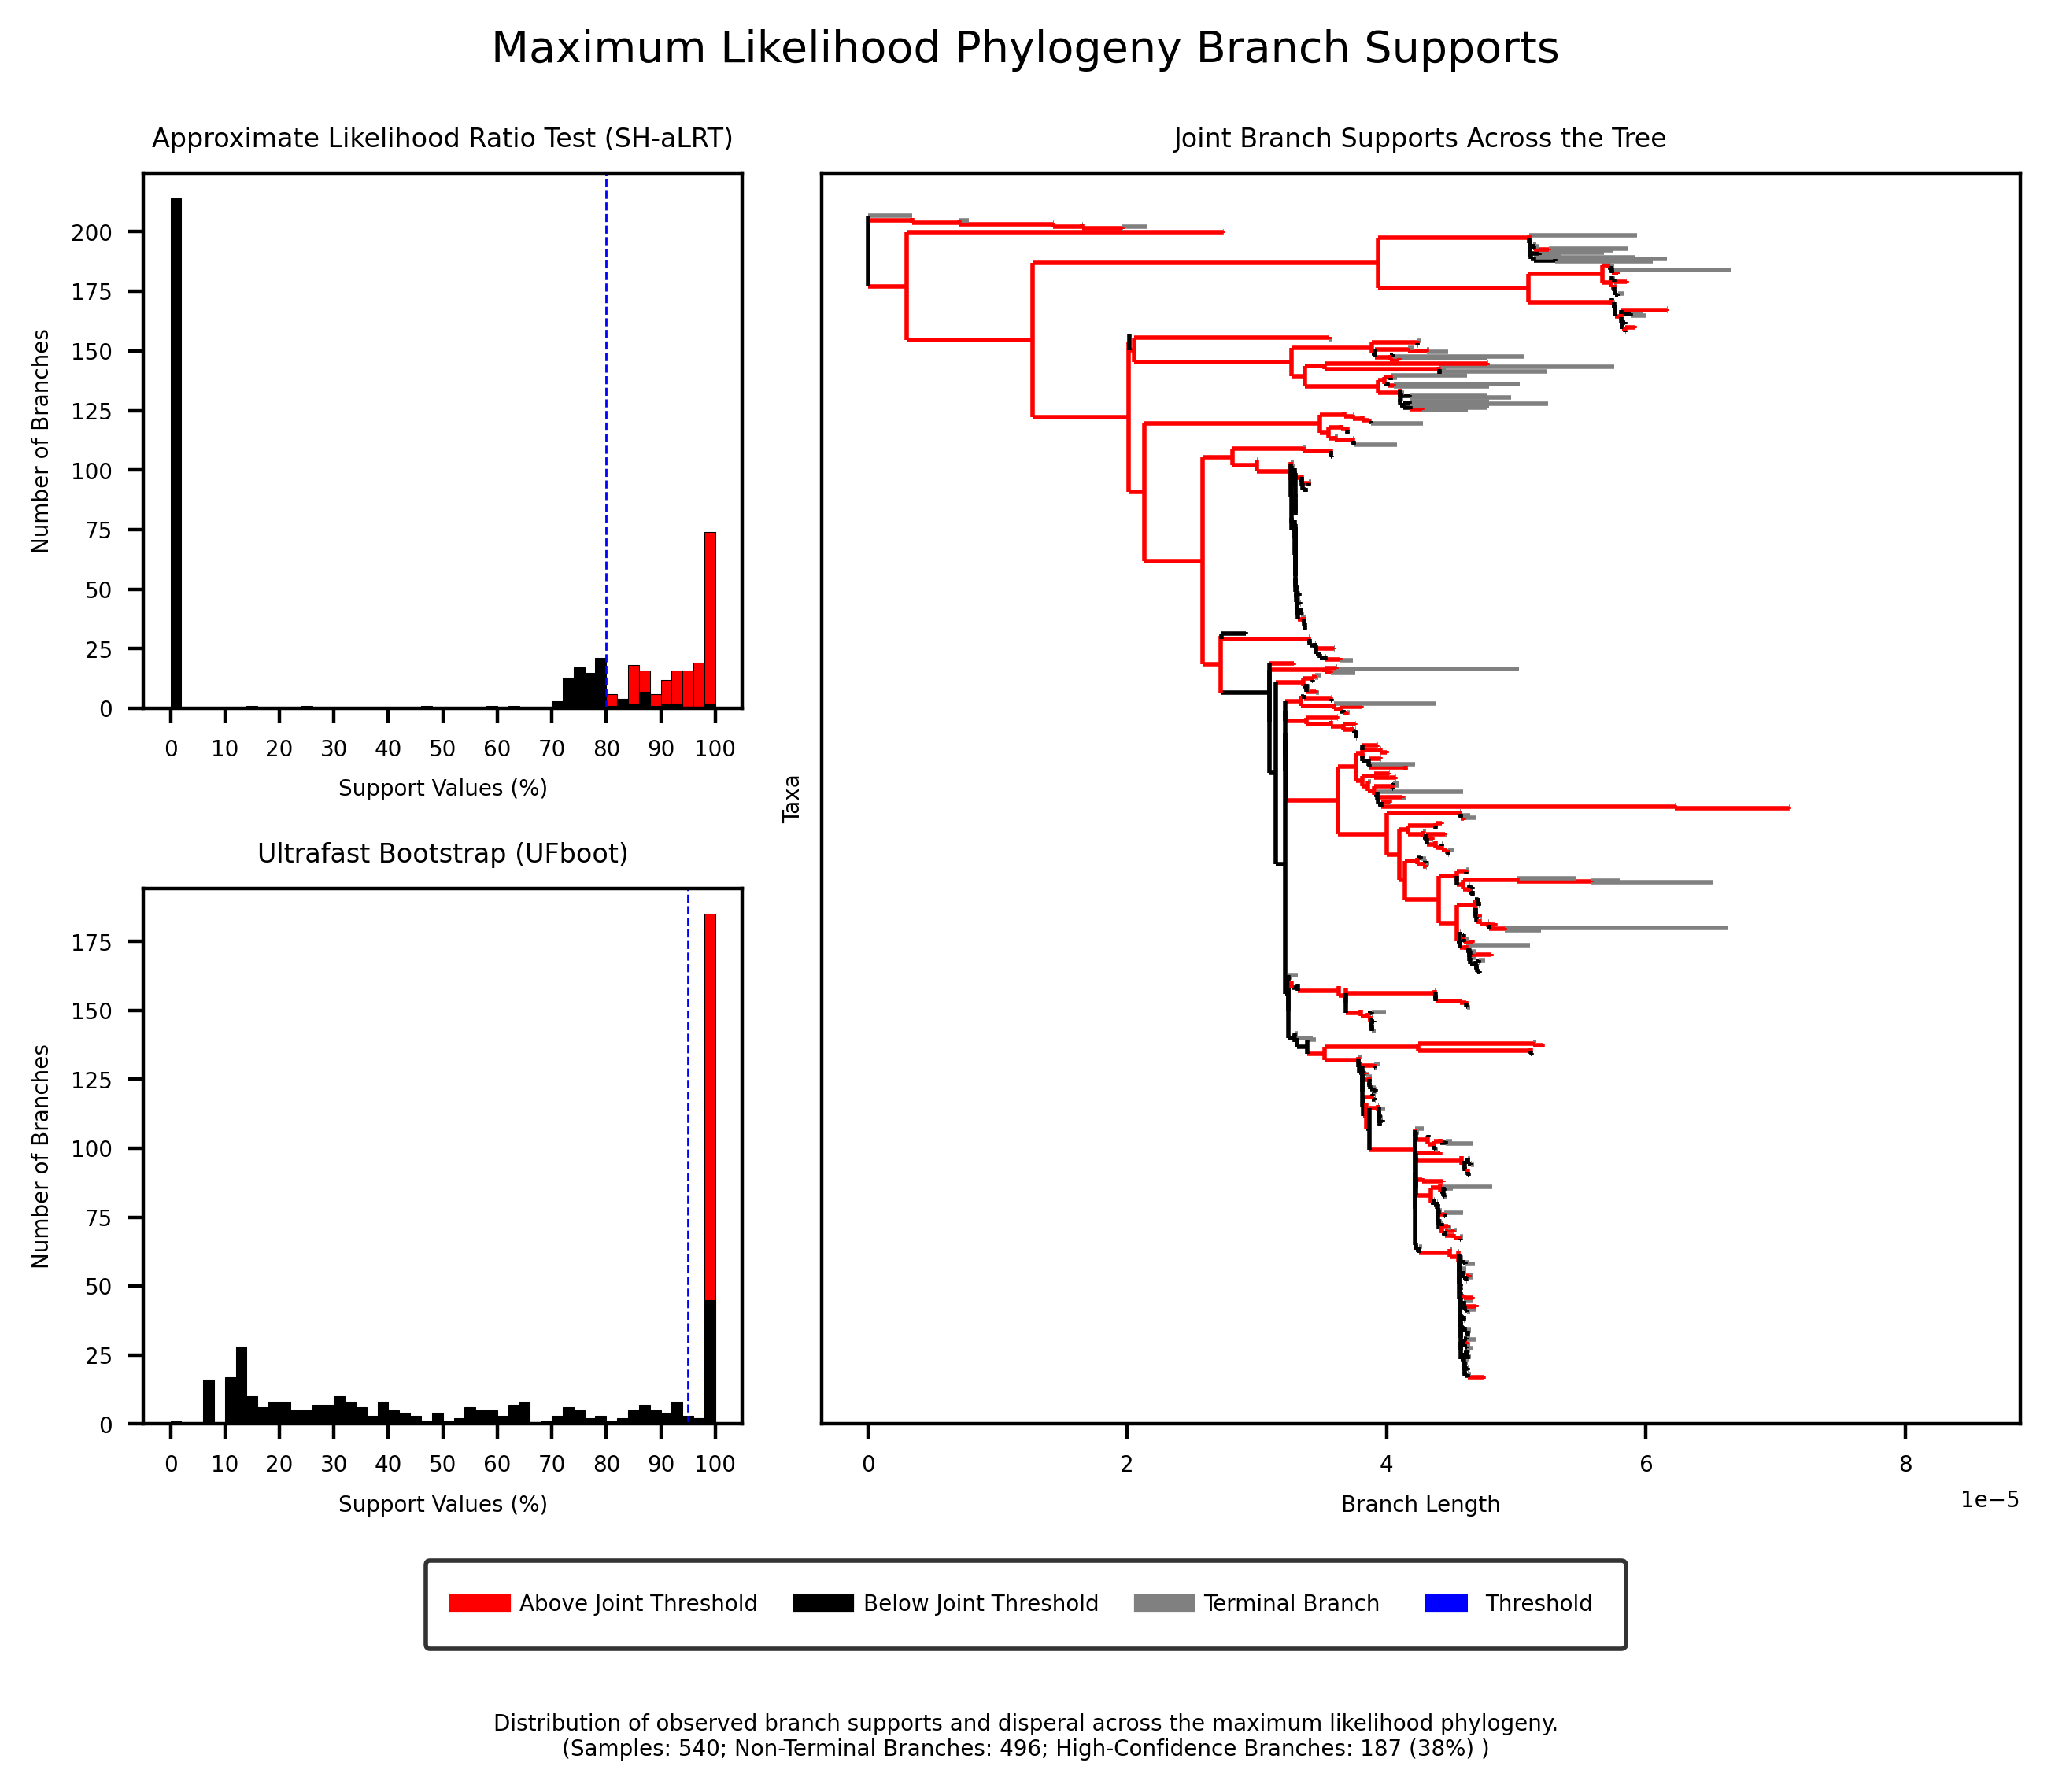

In [84]:
fig = plt.figure(constrained_layout=True, 
                 dpi=dpi,
                 figsize=figsize)

# Setup the grid
gs = gridspec.GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[0:, 1:3])

# Local plot variables
hist_bins = [x for x in range(0,101,2)]
xticks_major = [x for x in range(0,101,10)]

# Filter out NA values
data = tree_df[(tree_df['aLRT'] != NO_DATA_CHAR) & (tree_df['UFboot'] != NO_DATA_CHAR) ]

# -------------------------------
# aLRT Axis
sns.histplot(data, 
             x="aLRT", 
             ax=ax1,
             bins=hist_bins,
             hue="Branch_Support_Color",
             palette=[LOW_COL, HIGH_COL],
             legend=False,
             alpha=1)
ax1.axvline(x=ALRT_THRESH, color=THRESH_COL, linewidth=0.5, linestyle='--')
ax1.set_xticks(xticks_major, minor=False)
ax1.set_xticklabels(xticks_major)
ax1.set_xlabel("Support Values (%)")
ax1.set_ylabel('Number of Branches')
ax1.set_title('Approximate Likelihood Ratio Test (SH-aLRT)')

# -------------------------------
# UFboot Axis
sns.histplot(data, 
             x="UFboot", 
             ax=ax2,
             bins=hist_bins,
             hue="Branch_Support_Color",
             palette=[LOW_COL, HIGH_COL],
             legend=False,
             alpha=1)
ax2.axvline(x=UFBOOT_THRESH, color=THRESH_COL, linewidth=0.5, linestyle='--')
ax2.set_xticks(xticks_major, minor=False)
ax2.set_xticklabels(xticks_major)
ax2.set_ylabel('Number of Branches')
ax2.set_xlabel("Support Values (%)")
ax2.set_title('Ultrafast Bootstrap (UFboot)')

# -------------------------------
# Phylogeny
tree_div.ladderize(reverse=True)
Phylo.draw(tree_div,
           axes=ax3,
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)
ax3.set_xlabel('Branch Length')
ax3.set_ylabel('Taxa')
ax3.set_yticks([])
ax3.set_yticklabels([])
ax3.set_ylim(-20,len(tree_div.get_terminals())+20)
ax3.set_title("Joint Branch Supports Across the Tree")

"""# -------------------------------
# Annotations
# AE1175, DA101
first_pandemic_mrca = tree_div.common_ancestor("SAMEA4354665", "SAMEA1061800").name
# 8291, OBS137, STN008
second_pandemic_mrca = tree_div.common_ancestor("SAMEA4354665","SAMEA3713715", "SAMEA5818822").name

annot_dict = {"First Pandemic": {"node": first_pandemic_mrca},
              "Second Pandemic": {"node": second_pandemic_mrca},
             }

i = 0
for c in tree_div.find_clades():
    i += 1
    for annot in annot_dict:
        if c.name == annot_dict[annot]["node"]:
            annot_dict[annot]["x"] = tree_div.distance(c, tree_div.root)
            annot_dict[annot]["y"] = i
            break

# Now add annotations to plot
y_offset = 0
x_offset = 0
for annot in annot_dict:
    #x_offset = -0.000001 * len(annot)
    ax3.text(annot_dict[annot]["x"] + x_offset,
            annot_dict[annot]["y"] + y_offset, 
            annot,)
"""
# -------------------------------
# Figure title
fig.suptitle("Maximum Likelihood Phylogeny Branch Supports")

# -------------------------------
# Legend
legend_lines = [lines.Line2D([0], [0], color=HIGH_COL, lw=4),
                lines.Line2D([0], [0], color=LOW_COL, lw=4),
                lines.Line2D([0], [0], color=TERM_COL, lw=4),
                lines.Line2D([0], [0], color=THRESH_COL, lw=4, ls="--"),
               ]

legend_labels = ["Above Joint Threshold",
                 "Below Joint Threshold",
                 "Terminal Branch",
                 "Threshold"]
fig.legend(legend_lines, 
           legend_labels,
           ncol=len(legend_labels),
           loc="center", 
           bbox_to_anchor=(0.5, -0.05),
           frameon=True,
           borderpad=1.5,
           edgecolor="black") 

# -------------------------------
# Caption
num_terminal_nodes = len(tree_df[tree_df["Branch_Support_Color"] == TERM_COL])
num_internal_nodes = len(tree_df[tree_df["Branch_Support_Color"] != TERM_COL])
num_high_support = len(tree_df[tree_df["Branch_Support_Color"] == HIGH_COL])
num_low_support = len(tree_df[tree_df["Branch_Support_Color"] == LOW_COL])
perc_high_support = (num_high_support / num_internal_nodes) * 100

caption_text = ("Distribution of observed branch supports and disperal across the maximum likelihood phylogeny." 
                + "\n(" 
                + "Samples: {}".format(num_terminal_nodes) 
                + "; "
                + "Non-Terminal Branches: {}".format(num_internal_nodes)
                + "; "
                + "High-Confidence Branches: {0} ({1:.0f}%)".format(num_high_support, perc_high_support)
                + " )"
               )
fig.text(0.5, -0.15, caption_text, ha='center')

# -------------------------------
# Save figure
out_path = os.path.join(outdir, "branch-support.jpg") 
plt.savefig(out_path, dpi=400, bbox_inches = "tight")

# Save Tree File
out_path = os.path.join(outdir, "branch-support.xml" )
Phylo.write(tree_div, 
            out_path,
            "phyloxml")

---
## Cleanup

In [86]:
os.remove(tmp_xml)